# Question 1

To find the answer of this question you should run the following python code cells.

In [49]:
# Code for question 1

import numpy as np
from scipy.io import arff
import pandas as pd
from sklearn.base import TransformerMixin
from sklearn import tree
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import svm, datasets
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import sys
import warnings
import matplotlib.pyplot as plt 
%matplotlib inline

In [33]:
# fixed random seed
np.random.seed(1)

def warn(*args, **kwargs):
    pass

def label_enc(labels):
    le = preprocessing.LabelEncoder()
    le.fit(labels)
    return le

def features_encoders(features,categorical_features='all'):
    n_samples, n_features = features.shape
    label_encoders = [preprocessing.LabelEncoder() for _ in range(n_features)]

    X_int = np.zeros_like(features, dtype=np.int)

    for i in range(n_features):
        feature_i = features[:, i]
        label_encoders[i].fit(feature_i)
        X_int[:, i] = label_encoders[i].transform(feature_i)
        
    enc = preprocessing.OneHotEncoder(categorical_features=categorical_features)
    return enc.fit(X_int),label_encoders

def feature_transform(features,label_encoders, one_hot_encoder):
    
    n_samples, n_features = features.shape
    X_int = np.zeros_like(features, dtype=np.int)
    
    for i in range(n_features):
        feature_i = features[:, i]
        X_int[:, i] = label_encoders[i].transform(feature_i)

    return one_hot_encoder.transform(X_int).toarray()

warnings.warn = warn

In [34]:
class DataFrameImputer(TransformerMixin):

    def fit(self, X, y=None):

        self.fill = pd.Series([X[c].value_counts().index[0]
            if X[c].dtype == np.dtype('O') else X[c].mean() for c in X],
            index=X.columns)

        return self

    def transform(self, X, y=None):
        return X.fillna(self.fill)


def load_data(path):
    dataset = arff.loadarff(path)
    data = pd.DataFrame(dataset[0])
    attr = np.array(data.columns)
    data = DataFrameImputer().fit_transform(data).values

    # mask categorical features
    masks = []
    for i in range(len(attr)-1):
        if attr[i][1] != 'REAL':
            masks.append(i)
    return data, masks

def preprocess(data,masks, noise_ratio):
    # split data
    train_data, test_data = train_test_split(data,test_size=0.3,random_state=0)

    # test data
    test_features = test_data[:,0:test_data.shape[1]-1]
    test_labels = test_data[:,test_data.shape[1]-1]

    # training data
    features = train_data[:,0:train_data.shape[1]-1]
    labels = train_data[:,train_data.shape[1]-1]

    classes = list(set(labels))
    # categorical features need to be encoded
    if len(masks):
        one_hot_enc, label_encs = features_encoders(data[:,0:data.shape[1]-1],masks)
        test_features = feature_transform(test_features,label_encs,one_hot_enc)
        features = feature_transform(features,label_encs,one_hot_enc)

    le = label_enc(data[:,data.shape[1]-1])
    labels = le.transform(train_data[:,train_data.shape[1]-1])
    test_labels = le.transform(test_data[:,test_data.shape[1]-1])
    
    # add noise
    np.random.seed(1234)
    noise = np.random.randint(len(classes)-1, size=int(len(labels)*noise_ratio))+1
    
    noise = np.concatenate((noise,np.zeros(len(labels) - len(noise),dtype=np.int)))
    labels = (labels + noise) % len(classes)

    return features,labels,test_features,test_labels

In [37]:
# load data
paths = ['australian','labor','diabetes','ionosphere']
noise = [0,0.25,0.5,0.75]

scores = []
params = []

for path in paths:
    score = []
    param = []
    path += '.arff'
    data, masks = load_data(path)
    
    # training on data with 50% noise and default parameters
    features, labels, test_features, test_labels = preprocess(data, masks, 0.5)
    tree = DecisionTreeClassifier(random_state=0,max_depth=2, min_impurity_decrease=0)    
    tree.fit(features, labels)
    tree_preds = tree.predict(test_features)
    tree_performance = accuracy_score(test_labels, tree_preds)
    score.append(tree_performance)
    param.append(tree.get_params()['max_depth'])
    
    # training on data with noise levels of 0%, 25%, 50% and 75%
    for noise_ratio in noise:
        features, labels, test_features, test_labels = preprocess(data, masks, noise_ratio)
        param_grid = {'max_depth': np.arange(2,30,5)}

        grid_tree = GridSearchCV(DecisionTreeClassifier(random_state=0), param_grid,cv=10,return_train_score=True)
        grid_tree.fit(features, labels)

        estimator = grid_tree.best_estimator_
        tree_preds = grid_tree.predict(test_features)
        tree_performance = accuracy_score(test_labels, tree_preds)
        score.append(tree_performance)
        param.append(estimator.get_params()['max_depth'])

    scores.append(score)
    params.append(param)

# print the results
header = "{:^112}".format("Decision Tree Results") + '\n' + '-' * 112  + '\n' + \
"{:^15} | {:^16} | {:^16} | {:^16} | {:^16} | {:^16} |".format("Dataset", "Default", "0%", "25%", "50%", "75%") + \
 '\n' + '-' * 112  + '\n'

# print result table
print(header)
for i in range(len(scores)):
    #scores = score_list[i][1]
    print("{:<16}".format(paths[i]),end="")
    for j in range(len(params[i])):
        print("|  {:>6.2%} ({:>2})     " .format(scores[i][j],params[i][j]),end="")
    print('|\n')
print('\n')

                                             Decision Tree Results                                              
----------------------------------------------------------------------------------------------------------------
    Dataset     |     Default      |        0%        |       25%        |       50%        |       75%        |
----------------------------------------------------------------------------------------------------------------

australian      |  56.52% ( 2)     |  81.16% ( 7)     |  86.96% ( 2)     |  56.52% ( 2)     |  20.77% ( 7)     |

labor           |  66.67% ( 2)     |  94.44% ( 7)     |  44.44% ( 7)     |  66.67% ( 7)     |  50.00% (12)     |

diabetes        |  66.23% ( 2)     |  67.10% ( 7)     |  64.07% (12)     |  66.23% ( 2)     |  35.50% (27)     |

ionosphere      |  66.04% ( 2)     |  86.79% ( 7)     |  82.08% (27)     |  71.70% ( 7)     |  18.87% (12)     |





The item 4 is the correct answer for this question. 
We have selected the 'diabetes.arff' explain the reason visually. 
The following plot shows shows the accuracy score of decision tree classifier for all max_depth between 2 and 50. the black line shows the accuracy score for training set and the blue one shows this score for test set. the result clearly shows that by increasing the value of max_depth the overfitting is increased.

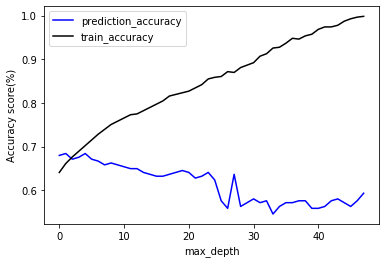

In [59]:
train_data, test_data = train_test_split(data,test_size=0.3,random_state=0)
data, masks = load_data('diabetes.arff')

score = []
score_train = [] 
for i in range(2,50):
    features, labels, test_features, test_labels = preprocess(data, masks, 0)
    tree = DecisionTreeClassifier(random_state=0,max_depth=i, min_impurity_decrease=0)    
    tree.fit(features, labels)
    tree_preds = tree.predict(test_features)
    tree_performance = accuracy_score(test_labels, tree_preds)
    train_preds = tree.predict(features)
    tree_performance_train = accuracy_score(labels, train_preds)
    score_train.append(tree_performance_train)
    score.append(tree_performance)

plt.plot(score,label='test_accuracy',color='blue')
plt.plot(score_train,label='train_accuracy',color='black')
plt.xlabel('max_depth')
plt.ylabel('Accuracy score(%)')
plt.legend()


# Question 2

In [1]:
#Libraries for Question 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics

In [2]:
### loading dataset
data=pd.read_csv("CreditCards.csv")
input_columns = ['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X7.1', 'X9', 'X10', 'X11', 'X12', 'X13', 'X14']
print(data.head())

   X1     X2     X3  X4  X5  X6     X7  X7.1  X9  X10  X11  X12  X13   X14  Y
0   1  22.08  11.46   2   4   4  1.585     0   0    0    1    2  100  1213  0
1   0  22.67   7.00   2   8   4  0.165     0   0    0    0    2  160     1  0
2   0  29.58   1.75   1   4   4  1.250     0   0    0    1    2  280     1  0
3   0  21.67  11.50   1   5   3  0.000     1   1   11    1    2    0     1  1
4   1  20.17   8.17   2   6   4  1.960     1   1   14    0    2   60   159  1


In [3]:
data.columns

Index(['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X7.1', 'X9', 'X10', 'X11',
       'X12', 'X13', 'X14', 'Y'],
      dtype='object')

In [4]:
##Pre-precessing (min_max Normalization) 
minimum = np.min(data,axis=0)
maximum = np.max(data,axis=0)
NormalData = (data - minimum)/(maximum-minimum)
print(NormalData)

      X1        X2        X3   X4        X5     X6        X7  X7.1   X9  \
0    1.0  0.125263  0.409286  0.5  0.230769  0.375  0.055614   0.0  0.0   
1    0.0  0.134135  0.250000  0.5  0.538462  0.375  0.005789   0.0  0.0   
2    0.0  0.238045  0.062500  0.0  0.230769  0.375  0.043860   0.0  0.0   
3    0.0  0.119098  0.410714  0.0  0.307692  0.250  0.000000   1.0  1.0   
4    1.0  0.096541  0.291786  0.5  0.384615  0.375  0.068772   1.0  1.0   
..   ...       ...       ...  ...       ...    ...       ...   ...  ...   
685  1.0  0.267970  0.375000  0.5  1.000000  0.375  0.228070   1.0  0.0   
686  1.0  0.104060  0.014821  0.5  0.538462  0.375  0.004386   0.0  0.0   
687  0.0  0.076391  0.340714  0.5  0.384615  0.375  0.002982   1.0  0.0   
688  0.0  0.205564  0.517857  0.5  1.000000  0.875  0.108246   1.0  1.0   
689  1.0  0.409774  0.001429  0.5  0.692308  0.375  0.001404   0.0  1.0   

          X10  X11  X12   X13      X14    Y  
0    0.000000  1.0  0.5  0.05  0.01212  0.0  
1    0.

In [5]:
###Train and test Split 
x_train = NormalData[input_columns].iloc[:621]
y_train = data['Y'].iloc[:621]
x_test = NormalData[input_columns].iloc[621:]
y_test = data['Y'].iloc[621:]

In [6]:
#### training KNN classifier with 2 number of neighbours
from sklearn.neighbors import KNeighborsClassifier
 
knn = KNeighborsClassifier(n_neighbors=2)
knn.fit(x_train, y_train)

train_accuracy = metrics.accuracy_score(y_train,knn.predict(x_train))
test_accuracy = metrics.accuracy_score(y_test,knn.predict(x_test))

print('Train Accuracy = ', train_accuracy , ', Test Accuracy = ', test_accuracy)



Train Accuracy =  0.8969404186795491 , Test Accuracy =  0.7681159420289855


In [7]:
training_scores = []
Test_scores = []
for k in range(1,30):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(x_train, y_train)    
    Test_scores.append(metrics.roc_auc_score(y_test, knn.predict_proba(x_test)[:,1]))
    training_scores.append(metrics.roc_auc_score(y_train, knn.predict_proba(x_train)[:,1]))

optimal_neighbours = np.argmax(Test_scores) + 1
print('optimal number of neighbour is = ', optimal_neighbours)

optimal number of neighbour is =  5


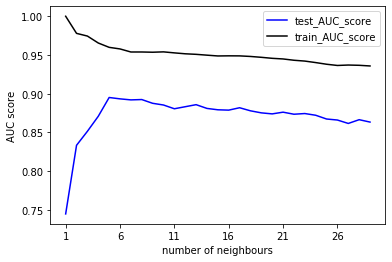

In [9]:
plt.plot(range(1,30),Test_scores,label='test_AUC_score',color='blue')
plt.plot(range(1,30),training_scores,label='train_AUC_score',color='black')
plt.xlabel('number of neighbours')
plt.ylabel('AUC score')
plt.xticks(np.arange(1, 30, step=5))
plt.legend()

In [11]:
knn_2 = KNeighborsClassifier(n_neighbors=2)
knn_2.fit(x_train, y_train)

knn_best = KNeighborsClassifier(n_neighbors=optimal_neighbours)
knn_best.fit(x_train, y_train)

print('KNN classifier with two neighbours')
print('Precision score = ', metrics.precision_score(y_test,knn_2.predict(x_test)))
print('Recall score = ', metrics.recall_score(y_test,knn_2.predict(x_test)))

print('\nKNN classifier with optimal number of neighbours')
print('Precision score = ', metrics.precision_score(y_test,knn_best.predict(x_test)))
print('Recall score = ', metrics.recall_score(y_test,knn_best.predict(x_test)))


KNN classifier with two neighbours
Precision score =  0.7894736842105263
Recall score =  0.5555555555555556

KNN classifier with optimal number of neighbours
Precision score =  0.7666666666666667
Recall score =  0.8518518518518519


In [17]:
## optimal number of neighbour with gridsearchcv10

In [14]:
from sklearn.model_selection import GridSearchCV
param_grid = {'n_neighbors': np.arange(1,30,1)}

grid_KNN = GridSearchCV(KNeighborsClassifier(), param_grid,cv=10, scoring='roc_auc')
#grid_KNN.fit(NormalData[input_columns], data['Y'])
grid_KNN.fit(x_train, y_train)

print(grid_KNN.best_params_)

{'n_neighbors': 15}


In [16]:
knn_2 = KNeighborsClassifier(n_neighbors=2)
knn_2.fit(x_train, y_train)

knn_best = KNeighborsClassifier(n_neighbors=grid_KNN.best_params_['n_neighbors'])
knn_best.fit(x_train, y_train)

print('KNN classifier with two neighbours')
print('Precision score = ', metrics.precision_score(y_test,knn_2.predict(x_test)))
print('Recall score = ', metrics.recall_score(y_test,knn_2.predict(x_test)))

print('\nKNN classifier with optimal number of neighbours')
print('Precision score = ', metrics.precision_score(y_test,knn_best.predict(x_test)))
print('Recall score = ', metrics.recall_score(y_test,knn_best.predict(x_test)))


KNN classifier with two neighbours
Precision score =  0.7894736842105263
Recall score =  0.5555555555555556

KNN classifier with optimal number of neighbours
Precision score =  0.8
Recall score =  0.7407407407407407
